In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [ ]:
file_path = '../data_source/premiums.xlsx'
df = pd.read_excel(file_path)
df.head(3)

In [ ]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

### Handle NA Values

In [ ]:
df.dropna(inplace=True)
df.isna().sum()

### Handle Duplicate values

In [47]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.717284,23.021150,15766.810189
std,15.000378,1.491953,24.221794,8419.995271
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


### Handle Outliers

In [48]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [49]:
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [31]:
df[df.age > 100]['age'].unique()

array([224, 124, 136, 203, 356])

In [32]:
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

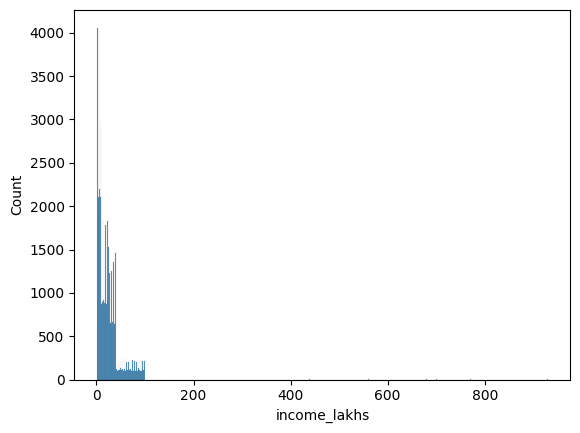

In [33]:
sns.histplot(df1.income_lakhs)

In [34]:
df1.income_lakhs.quantile([0.25,0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [35]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [36]:
get_iqr_bounds(df1.income_lakhs)

(-29.0, 67.0)

In [42]:
quantile_threshold = df1.income_lakhs.quantile(.999)

In [44]:
df1[df1.income_lakhs > quantile_threshold].shape

(10, 13)

In [50]:
df2 = df1[df1.income_lakhs < quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49808.000000,49808.000000,49808.000000,49808.000000
mean,34.399333,1.717214,22.735083,15756.332276
std,13.683206,1.492056,21.921788,8417.581174
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8602.000000
50%,31.000000,2.000000,16.000000,13919.000000
75%,45.000000,3.000000,31.000000,22263.250000
max,72.000000,5.000000,99.000000,43471.000000


In [51]:
numeric_columns = df.select_dtypes(include=['int', 'float']).columns

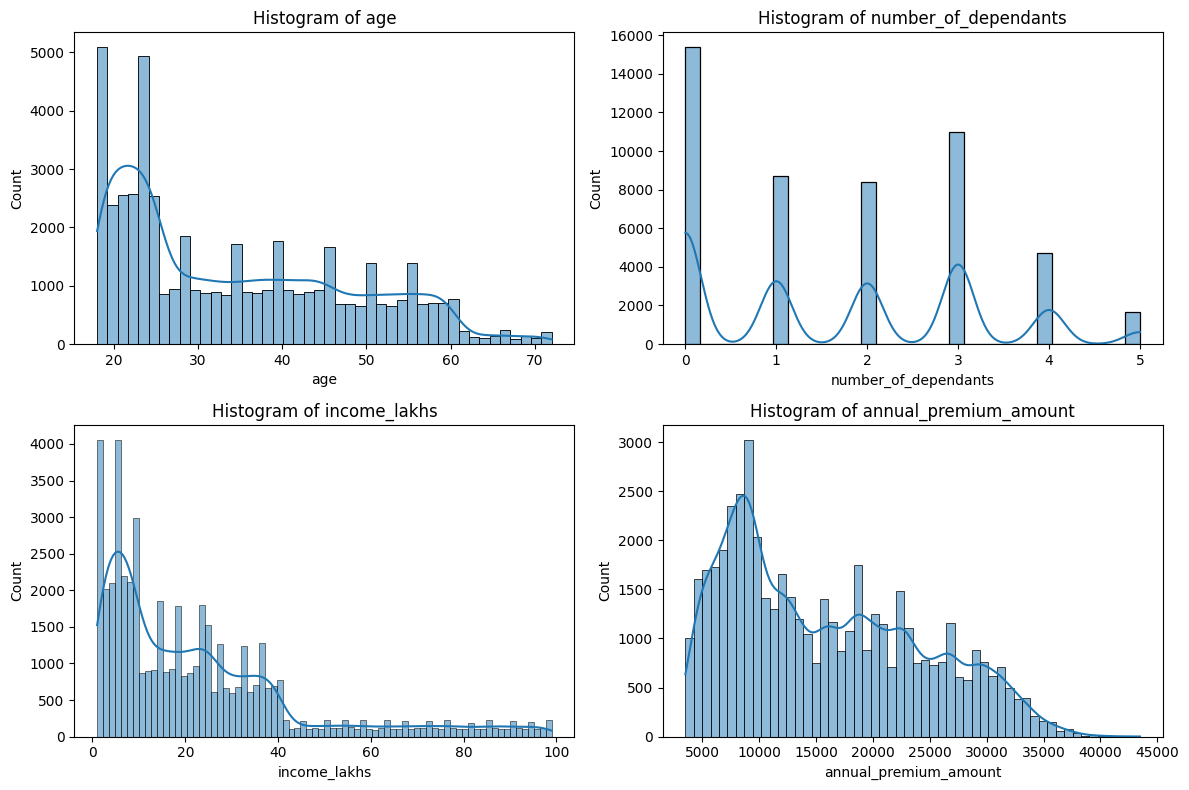

In [53]:
numeric_columns = df2.select_dtypes(include=['int', 'float']).columns

fig, axes = plt.subplots(2, 2, figsize=(12, 8))


axes = axes.flatten()
for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [54]:
df2.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

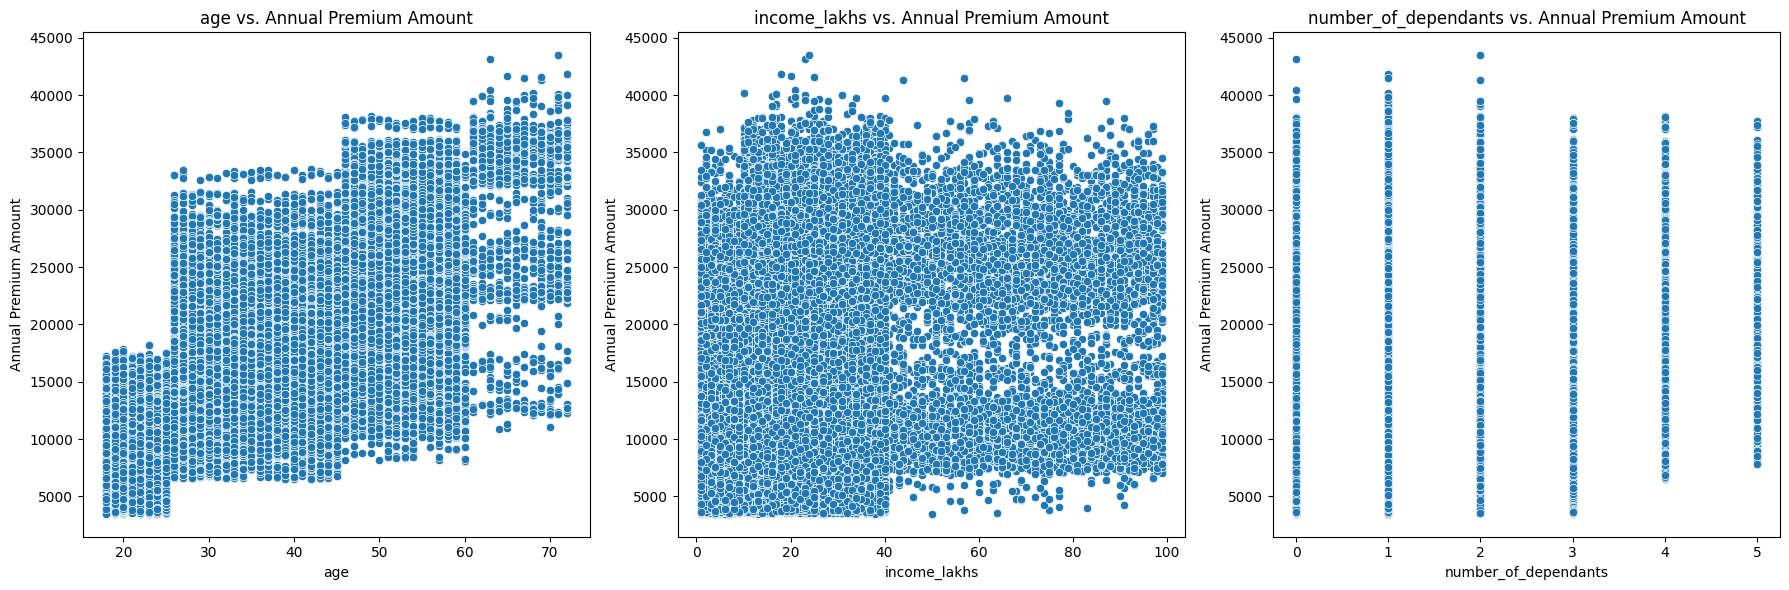

In [56]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

In [68]:
categorical_cols = df.select_dtypes(include=['object']).columns

'NorthwestSoutheastNortheastSouthwest'

In [60]:
for col in categorical_cols:
    print(col, ":" ,df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [71]:
df2['smoking_status'].replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
}, inplace = True)

df2['smoking_status'].unique()


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

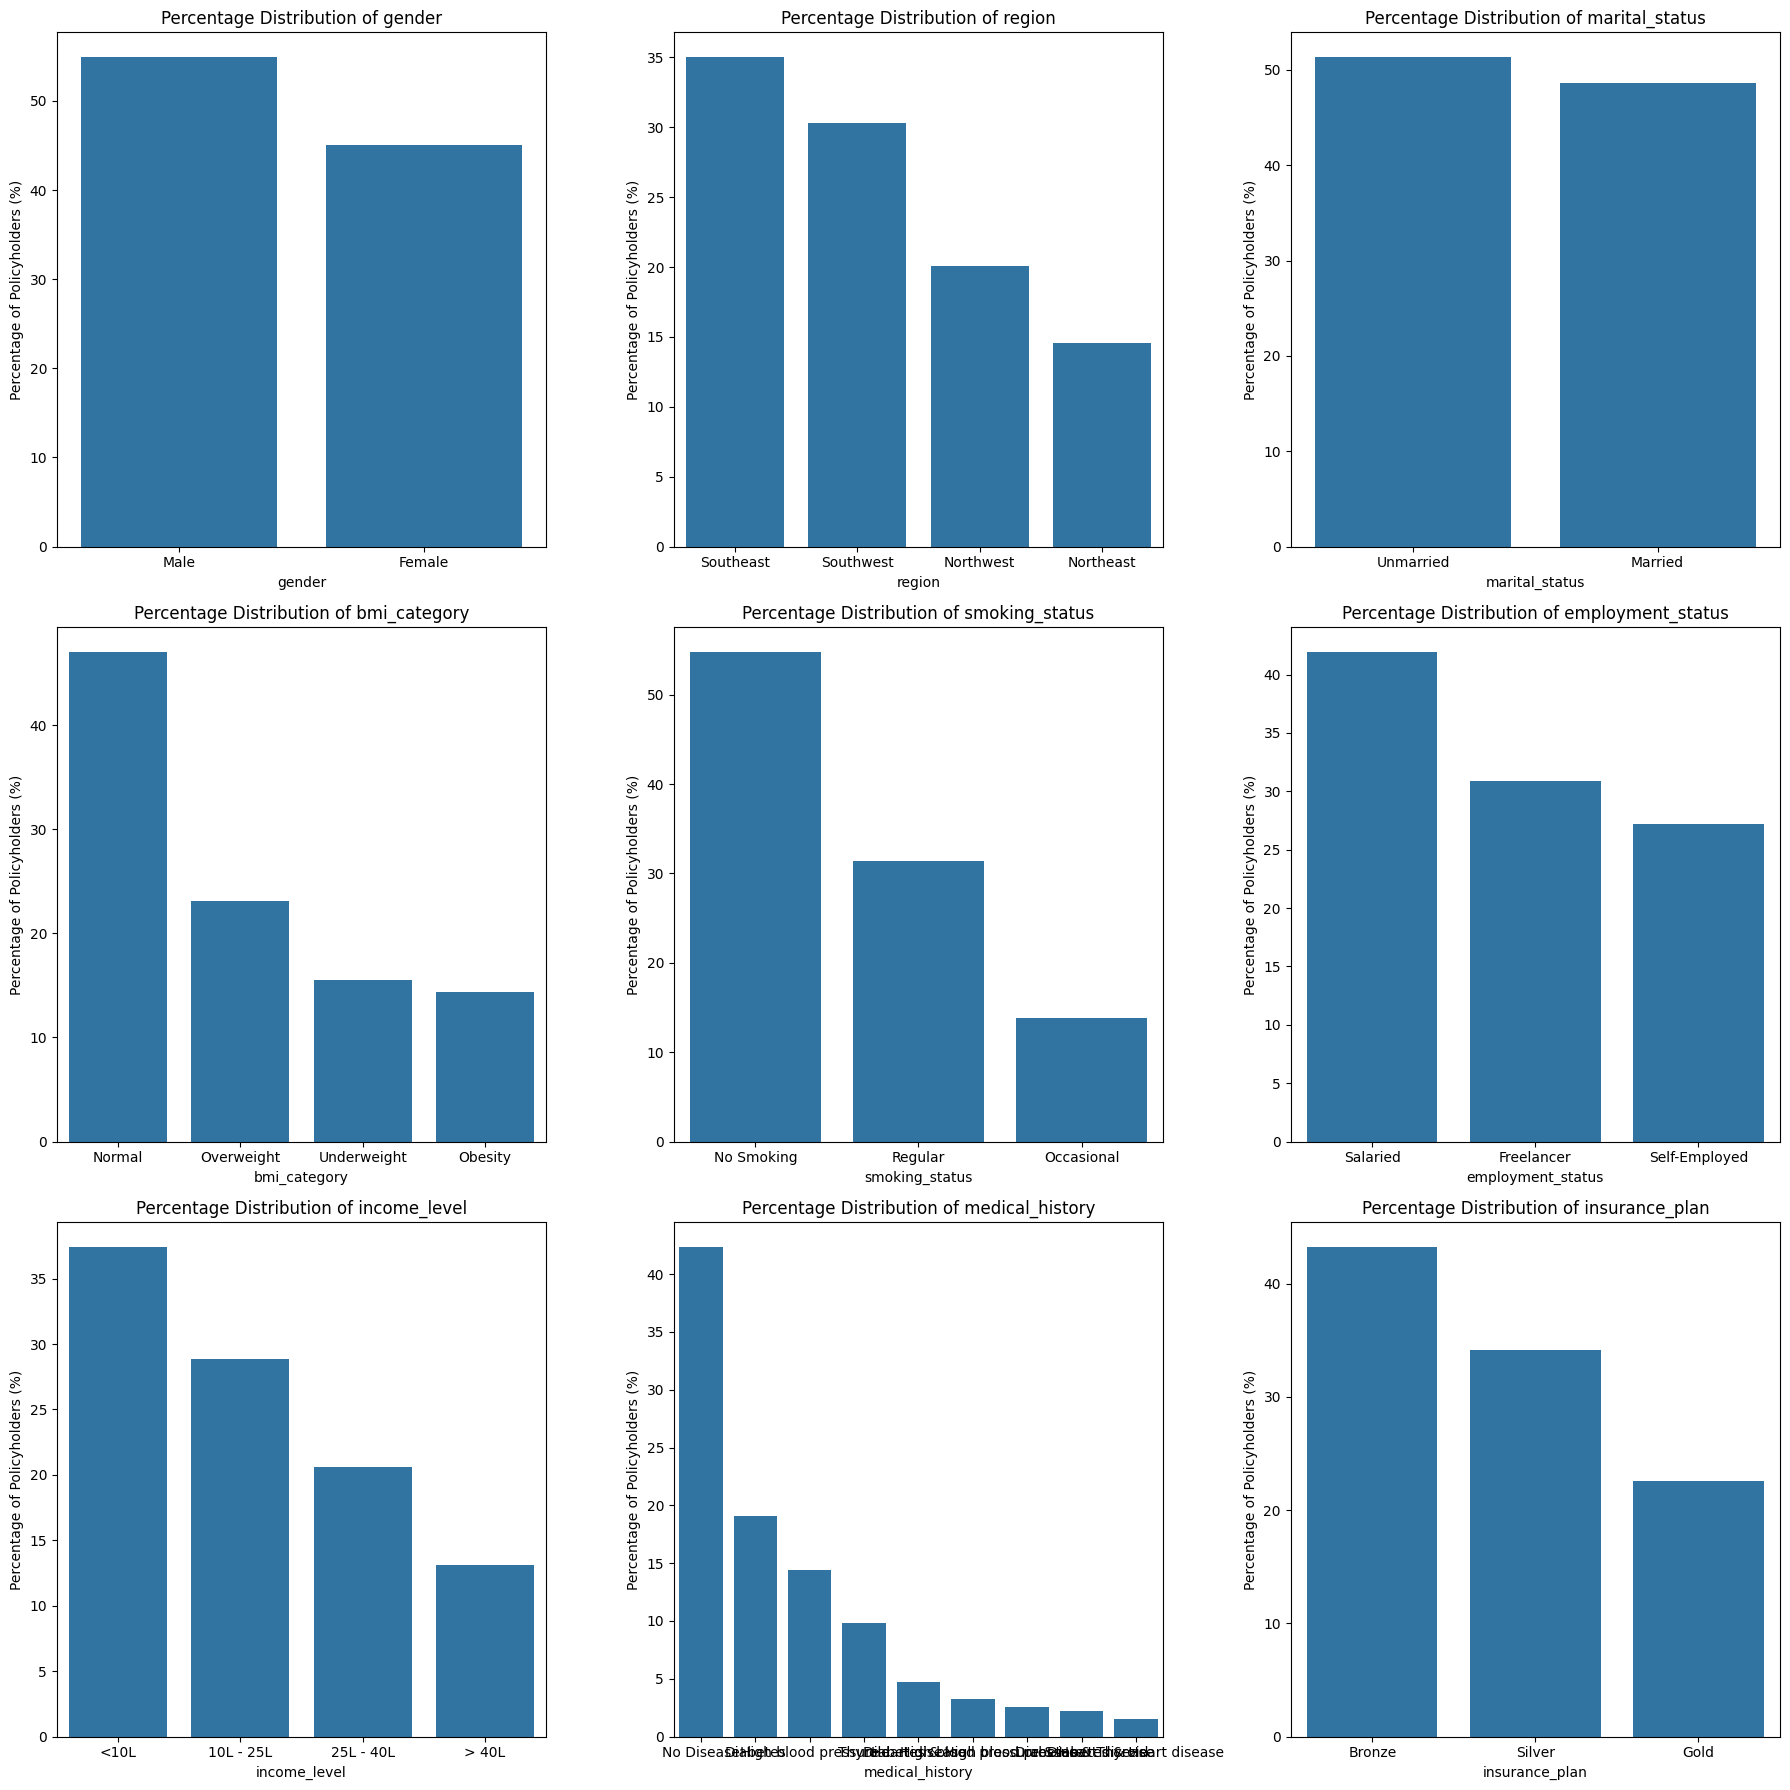

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  
axes = axes.flatten()  

for ax, column in zip(axes, categorical_cols):
    category_counts = df2[column].value_counts(normalize=True) * 100  

    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column) 

plt.tight_layout() 
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              326  3593    2604


<Axes: xlabel='income_level'>

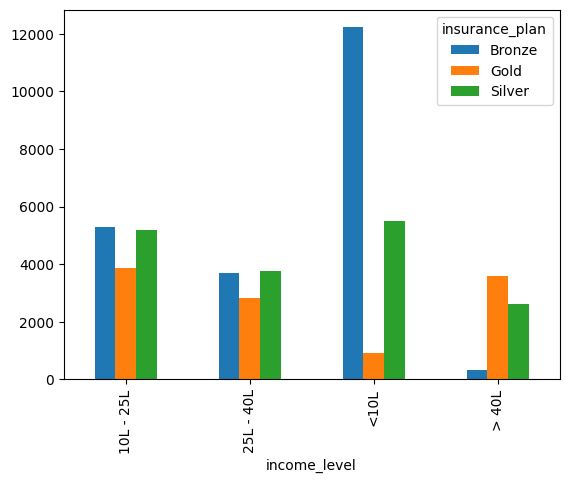

In [77]:
cross_stab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(cross_stab)

cross_stab.plot(kind = "bar")

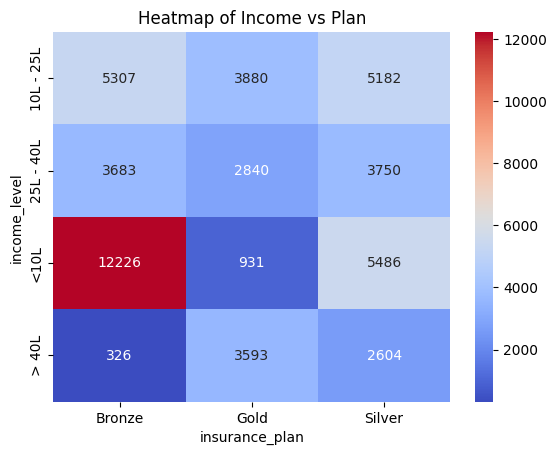

In [78]:
sns.heatmap(cross_stab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()